Import zipcodes into dataframe

In [ ]:
import pandas as pd

# Load data from a CSV file
df_zipcodes = pd.read_csv(r'..\assets\zipcodes_belgie.csv')



Query the databases for 'kapsalon'
Put output into dataframe

In [3]:
import sqlite3
import pandas as pd

query_4_d = """
    SELECT
        DISTINCT(locations.name)
    FROM
        locations
        JOIN locations_to_restaurants ON locations.id = locations_to_restaurants.location_id
        JOIN restaurants ON locations_to_restaurants.restaurant_id = restaurants.id
        JOIN menu_items ON restaurants.id = menu_items.restaurant_id
    WHERE
        menu_items.name LIKE 'kapsalon';
"""
query_4_deli_avg = """
SELECT
    locations.name, locations.longitude, locations.latitude, 
    AVG(CASE WHEN menu_items.name LIKE '%kapsalon%' THEN menu_items.price ELSE NULL END) AS avg_price_per_location
FROM
    locations
JOIN locations_to_restaurants ON locations.id = locations_to_restaurants.location_id
JOIN restaurants ON locations_to_restaurants.restaurant_id = restaurants.id
JOIN menu_items ON restaurants.id = menu_items.restaurant_id
WHERE
    menu_items.name LIKE '%kapsalon%'
GROUP BY
    locations.name
ORDER BY
	locations.name;
"""

query_4_take = """
    SELECT
        DISTINCT(locations.city)
    FROM
        locations
        JOIN locations_to_restaurants ON locations.ID = locations_to_restaurants.location_id
        JOIN restaurants ON locations_to_restaurants.restaurant_id = restaurants.primarySlug
        JOIN menuItems ON restaurants.primarySlug = menuItems.primarySlug
    WHERE
        menuItems.name LIKE 'Kapsalon';
"""

query_4_uber = """
    SELECT
        DISTINCT(locations.name)
    FROM
        locations
        JOIN locations_to_restaurants ON locations.id = locations_to_restaurants.location_id
        JOIN restaurants ON locations_to_restaurants.restaurant_id = restaurants.id
        JOIN menu_items ON restaurants.id = menu_items.restaurant_id
    WHERE
        menu_items.name LIKE 'Kapsalon';
"""

query_4_test = """
    SELECT
        name
    FROM
        restaurants
    WHERE
        ratings > 4;
"""

connection = sqlite3.connect(r"..\databases\deliveroo.db")
cursor = connection.cursor()

cursor.execute(query_4_deli_avg)
results = cursor.fetchall()

columns = ["kerk", "longitude", "latitude","avg_price_kapsalon"]
df = pd.DataFrame(results, columns = columns)

print(df.head(5))

cursor.close()


                            kerk  longitude   latitude  avg_price_kapsalon
0                              0   4.403686  51.220333            9.051431
1       AZ Delta campus Westlaan   3.115668  50.937545            8.423077
2                      Abdijkerk   4.736131  50.891787            8.117021
3  Abdijkerk Sint-Jan Evangelist   4.717629  50.864777            7.972727
4        Academie: Bogardenkapel   3.226934  51.201638           10.247500


In [4]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
from shapely.geometry import Point


[<POINT (4.404 51.22)>, <POINT (3.116 50.938)>, <POINT (4.736 50.892)>, <POINT (4.718 50.865)>, <POINT (3.227 51.202)>, <POINT (4.411 50.928)>, <POINT (4.7 50.873)>, <POINT (3.227 51.208)>, <POINT (4.412 51.197)>, <POINT (3.765 51.056)>, <POINT (3.729 51.058)>, <POINT (4.098 51.027)>, <POINT (4.474 51.032)>, <POINT (3.223 51.201)>, <POINT (2.915 51.202)>, <POINT (3.722 51.066)>, <POINT (4.45 51.233)>, <POINT (4.743 50.886)>, <POINT (4.43 50.873)>, <POINT (3.121 50.947)>, <POINT (4.688 50.863)>, <POINT (4.401 51.22)>, <POINT (4.394 50.74)>, <POINT (3.208 51.215)>, <POINT (3.267 50.829)>, <POINT (5.344 50.929)>, <POINT (3.706 51.034)>, <POINT (4.14 51.166)>, <POINT (3.717 51.06)>, <POINT (3.259 50.822)>, <POINT (4.497 51.042)>, <POINT (3.145 50.933)>, <POINT (4.435 51.188)>, <POINT (3.108 50.951)>, <POINT (4.158 51.162)>, <POINT (3.221 51.216)>, <POINT (3.234 51.215)>, <POINT (5.503 51.009)>, <POINT (4.674 50.851)>, <POINT (4.47 51.043)>, <POINT (4.957 51.331)>, <POINT (3.263 50.833)>, <

Text(0.5, 1.0, 'Average kapsalon prices in Belgium')

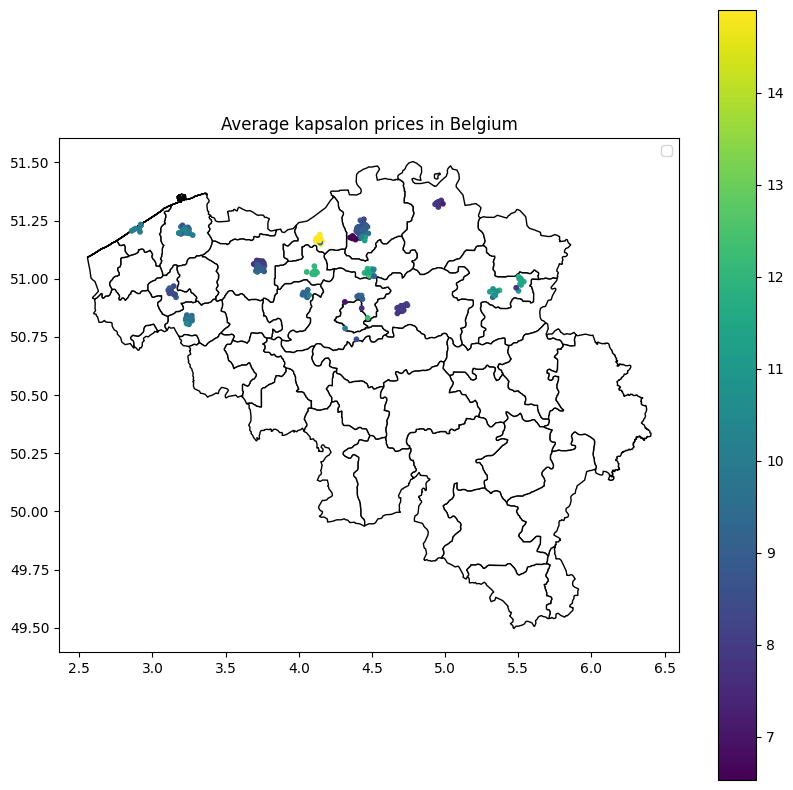

In [5]:
# Load data (above)

# Creating point geometry with Longitude and Latitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
print(geometry)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Setting the reference frame (CRS), e.g. EPSG:4326
gdf.set_crs(epsg=4326, inplace=True)

# Load administrative boundaries (e.g. Belgium)
# Replace 'path/to/belgium_shapefile.shp' with the path to your file
# Downloaded from: https://gadm.org/download_country.html#google_vignette
borders = gpd.read_file(r"..\assets\geo\gadm41_BEL_3.shp")

# Set the frame of reference for the boundaries if different (for example EPSG:4326)
#borders = borders.to_crs(epsg=4326)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Draw administrative boundaries on the map
borders.plot(ax = ax, color='white', edgecolor='black', linewidth=1) 

# Draw price points (Price)
scatter = gdf.plot(ax=ax, 
                   column='avg_price_kapsalon', 
                   cmap='viridis',  # Color map
                   legend=True, 
                   markersize=10)

# Add a legend
handles, labels = scatter.get_legend_handles_labels()
ax.legend(handles, [f'{int(float(label))}' for label in labels])


plt.title('Average kapsalon prices in Belgium')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.grid()
#plt.show()

In [ ]:
import folium
import numpy as np
import webbrowser
from folium.plugins import MarkerCluster

# Remove rows that have NaN in the latitude or longitude columns
df_clean = df.dropna(subset=['latitude', 'longitude'])

# Create a map with the appropriate center
properties = folium.Map(location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()], zoom_start=10)

folium.TileLayer('Stamen Toner', attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap').add_to(properties)

# Add MarkerCluster to improve performance with large numbers of markers
marker_cluster = MarkerCluster().add_to(properties)

# Add tags to the cluster
for index, row in df_clean.iterrows():
    text = f"""
    Price: {round(row.avg_price_kapsalon,2)} €<br>
    Count: TEAM 4 ROCKS !<br>
    """
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=folium.Popup(text, max_width=400),
        tooltip=round(row.avg_price_kapsalon,2)
    ).add_to(marker_cluster)

properties

# Save map to the html
map_path = r"..\assets\geo\map.html"
properties.save(map_path)

# Open map in browser
webbrowser.open(map_path)


True